# Mini-Nerdle Solver Test
We prove (by brute-force) that you can always solve mini-Nerdle in at most $4$ guesses regardless of the starting expression, provided you use the optimal strategy. The worst start having repeating numbers and thus less information, e.g. `10-5=5`. The best start has all different numbers: `28/7=4`, which needs at most $3$ guesses and $2.65 \pm 0.5$ guesses.

In [249]:
%load_ext autoreload
%autoreload 2

import collections
import itertools
import numpy as np
import matplotlib.pyplot as plt

import nerdle
import score as s
import generator
from nerdle import Hint, NerdleData

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [251]:
# Mini-Nerdle.
NUM_SLOTS = 6
SCORE_DICT_FILE = "mini_nerdle"

solver_data = nerdle.create_solver_data(NUM_SLOTS, SCORE_DICT_FILE)
solver_data.open();

0 / 42436 (0.0%) completed


In [252]:
d = solver_data.score_dict
print(len(d), len(solver_data.answers))
for key in list(d.keys())[:10]:
    print(key, "".join(map(str, key[0])) + "=" + str(key[1]), len(d[key]))

206 206
8+3=11 8=+ 206
7*9=63 7=* 206
5*9=45 5=* 206
72/9=8 7=2 206
11-4=7 1=1 206
6+6=12 6=+ 206
3*9=27 3=* 206
7*3=21 7=* 206
12-3=9 1=2 206
30/5=6 3=0 206


## Example Usage

In [253]:
score = nerdle.score_guess("54/9=6", "4*7=28")
print(score, 
      s.score_to_hint_string(score, NUM_SLOTS),
      s.score_to_hints(score, NUM_SLOTS) == [Hint.INCORRECT, Hint.MISPLACED, Hint.INCORRECT, Hint.INCORRECT, Hint.MISPLACED, Hint.INCORRECT]
     )

520 -?--?- True


In [254]:
# A good initial guess significantly reduces the number of answers. In this case, from
# 206 to 10.
guess_history, hint_history =  nerdle.NerdleSolver(solver_data).solve("4*3=12", initial_guess="56/7=8", debug=True)

guess 56/7=8 score ----?- answers 10
guess 3+9=12 score ?--+++ answers 1
guess 4*3=12 score ++++++ answers 1


## Benchmark
This is a fast in-memory dict implementation.

In [277]:
%timeit guess_history, hint_history, answer_size_history =  nerdle.NerdleSolver(solver_data).solve("4*3=12", initial_guess="56/7=8")

2.79 ms ± 58.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Initial Guess Optimization

In [193]:
# For each initial guess, calculate the distribution of #guesses required to get the answer, over all answers.
# This takes ~1.3s / initial guess = 4.5 min total.
num_guesses = np.array([
    [len(nerdle.NerdleSolver(solver_data).solve(answer, initial_guess=start)[1]) for answer in solver_data.answers]
    for start in solver_data.answers
])

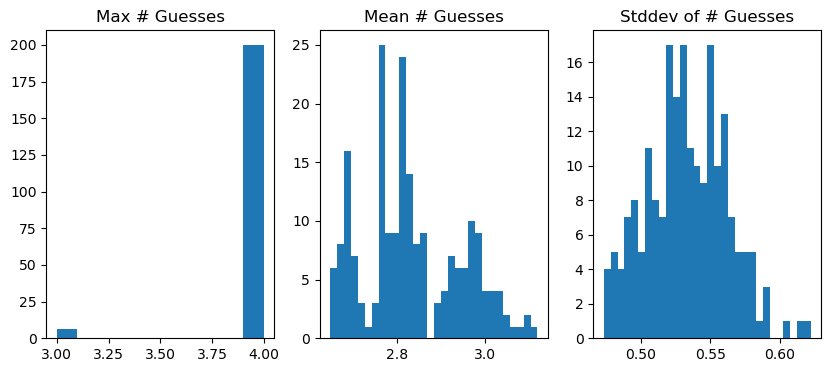

In [194]:
fig, axs = plt.subplots(1, 3, figsize=(10, 4))

ax = axs[0]
ax.hist(np.max(num_guesses, axis=1))
ax.set_title("Max # Guesses")

ax = axs[1]
ax.hist(np.mean(num_guesses, axis=1), 30)
ax.set_title("Mean # Guesses")

ax = axs[2]
ax.hist(np.std(num_guesses, axis=1), 30)
ax.set_title("Stddev of # Guesses");

In [195]:
# Best starts.
worst_num_guesses = np.max(num_guesses, axis=1)
print("Min (max # guesses)", min(worst_num_guesses))
idx = np.where(worst_num_guesses == min(worst_num_guesses))[0]
print(idx)
best_starts = np.array(solver_data.answers)[idx]

print("Best starts", best_starts)
mean_best = np.mean(num_guesses[idx], axis=1)
mean_best_argmin = np.argmin(mean_best)
print("Best mean # guesses among those {} mean # guesses {:.2f} +- {:.2f} idx {}".format(
    solver_data.answers[idx[mean_best_argmin]], mean_best[mean_best_argmin], np.std(num_guesses[idx[mean_best_argmin]]),
    idx[mean_best_argmin]))

# Worst starts.
print("Max (max # guesses)", max(worst_num_guesses))
idx = np.where(worst_num_guesses == max(worst_num_guesses))[0]
print(idx)
worst_starts = np.array(solver_data.answers)[idx]

print("Worst starts", worst_starts)

Min (max # guesses) 3
[ 81  82 136 137 161 177]
Best starts ['28/4=7' '28/7=4' '56/7=8' '56/8=7' '7*8=56' '8*7=56']
Best mean # guesses among those 28/7=4 mean # guesses 2.65 +- 0.49 idx 82
Max (max # guesses) 4
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109
 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127
 128 129 130 131 132 133 134 135 138 139 140 141 142 143 144 145 146 147
 148 149 150 151 152 153 154 155 156 157 158 159 160 162 163 164 165 166
 167 168 169 170 171 172 173 174 175 176 178 179 180 181 182 183 184 185
 186 187 188 189 190 191 192 193 194 195 196 197 198 199 2

69.0 55.72032026428142


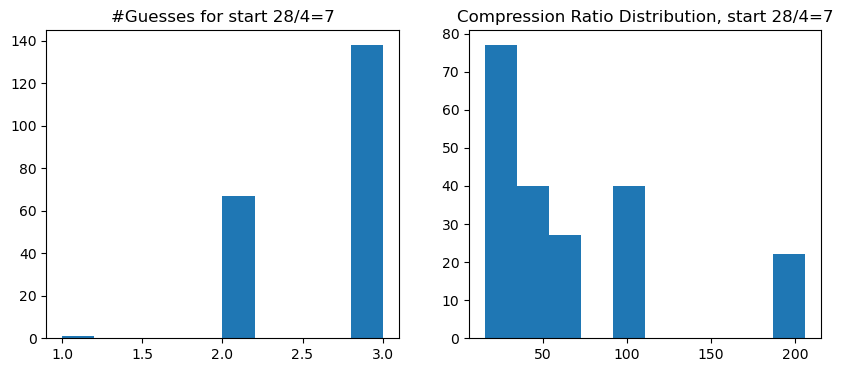

In [276]:
# Every initial guess' distribution of #guesses has to have a single "1" value.
start = best_starts[0]
solutions = [nerdle.NerdleSolver(solver_data).solve(answer, initial_guess=start) 
             for answer in solver_data.answers ]               
n = np.array([len(solution[0]) for solution in solutions])
num_answers = len(solver_data.answers)
compression_ratio = num_answers / np.array([solution[2][0] for solution in solutions])
print(np.mean(compression_ratio), np.std(compression_ratio))

fig, axs = plt.subplots(1, 2, figsize=(10, 4))

ax = axs[0]
ax.hist(n);
ax.set_title("#Guesses for start {}".format(start));

ax = axs[1]
ax.hist(compression_ratio);
ax.set_title("Compression Ratio Distribution, start {}".format(start));

## #Answers vs. #Slots
As expected, this rises very quickly (expontentially?) with #answers.

In [197]:
slots = np.arange(5, 9)
num_answers = np.array([len(list(nerdle.all_answers(s))) for s in slots])
print(num_answers)

[  127   206  6661 17723]


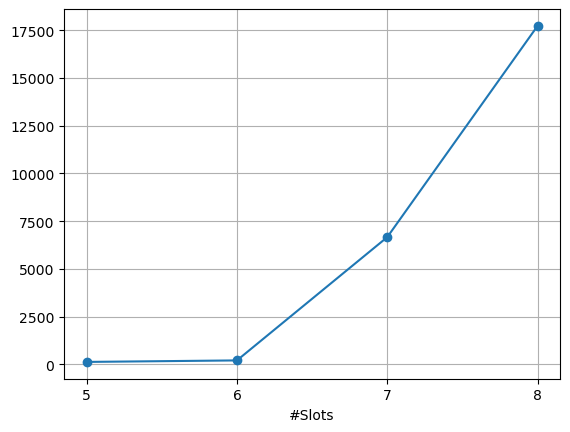

In [198]:
plt.plot(slots, num_answers, 'o-')
plt.xlabel("#Slots");
plt.grid(True);
plt.xticks(slots);

In [200]:
{2: {2:3, 4:5}, 3: {6:7, 8:9}}.copy()

{2: {2: 3, 4: 5}, 3: {6: 7, 8: 9}}

In [ ]:
solver_data.close()